# CanYouCatchIt?
A web application allowing you to obtain the percentage of chance that your bus/tram/metro is late. 💻🤖🎲🚌 🚎🚇🔮

_Build with the STIB API (available [here](https://opendata.stib-mivb.be/store/))_

# Notes: Making some models 💻🤖🚌 🚎🚇
We are here to make some machine learning models

## Load the data

In [1]:
# import
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import os

def load_delay_data():
    """
    Load the cvs file in a panda dataframe
    """
    return pd.concat([pd.read_csv(f) for f in glob.glob('../data/delay*.csv')], ignore_index = True)

# load the csv file
delay = load_delay_data()
delay.dropna(inplace=True)
delay.reset_index(drop=True, inplace=True)

# Get names of indexes for which column line has not a value of 39
index_to_remove = delay[delay['line'] != 39].index
# Delete these row indexes from dataFrame
delay.drop(index_to_remove , inplace=True)

nunique = delay.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
delay = delay.drop(cols_to_drop, axis=1)

delay = delay.drop(['trip', 'theoretical_time', 'expectedArrivalTime', 'date'], axis=1)

# Reset the labels
delay.reset_index(drop=True, inplace=True)

# Stratifie the data with the different line
# This make sure that the representation of each stop is the same in the train set then in the overall dataset
# This stratification is not necessary is you have enough data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(delay, delay["hour"]):
    strat_train_set = delay.loc[train_index]
    strat_test_set = delay.loc[test_index]

## Prepare the Data for Machine Learning Algorithms

In [2]:
delay = strat_train_set.drop("delay", axis=1) # drop labels for training set
delay_labels = strat_train_set["delay"].copy()

### Check if there is row with nan

Count the number of row with a nan value

In [3]:
sample_incomplete_rows = delay[delay.isnull().any(axis=1)].head()
len(sample_incomplete_rows.index)

0

### Check if there is attribute that are the same for every row

In [4]:
def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)
unique_cols(delay)

array([False, False, False, False, False, False, False, False, False])

In [5]:
delay.columns

Index(['stop', 'day', 'hour', 'minute', 'temp', 'humidity', 'visibility',
       'wind', 'rain'],
      dtype='object')

### Data Cleaning

Drop the unnecesery attribute. theoretical_time and expectedArrivalTime are droped because they are string attribute and they are not linked to the delay value. The date attribute is split into hour minute and seconds so it can be droped. The transport_type, year, month, visibility and rain attribute is droped because, it's the same for every row.

In [6]:
nunique = delay.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
delay = delay.drop(cols_to_drop, axis=1)
delay.head()

,stop,day,hour,minute,temp,humidity,visibility,wind,rain
39910,5508,0,19,27,281.35,87.0,10000.0,1.0,0.0
22073,5529,5,9,1,280.13,81.0,10000.0,4.6,0.0
42184,5512,1,7,33,280.11,93.0,10000.0,2.6,0.0
40202,5515,0,20,10,281.71,87.0,10000.0,1.5,0.0
52515,5519,2,22,58,280.81,81.0,10000.0,4.1,0.0


## Handling Text and Categorical Attributes
### Extract the non-numerical attributes

In [7]:
delay_num = delay.drop(['stop'], axis=1)

### Categorical Attributes: The stop and attributes

In [8]:
delay_cat = delay[['stop']]
delay_cat.head()

,stop
39910,5508
22073,5529
42184,5512
40202,5515
52515,5519


In [9]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
delay_cat_encoded = ordinal_encoder.fit_transform(delay_cat)
delay_cat_encoded[:10]

array([[ 7.],
       [16.],
       [10.],
       [11.],
       [15.],
       [ 1.],
       [12.],
       [ 8.],
       [10.],
       [14.]])

## Transformation Pipelines



In [10]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

def add_extra_features(X, add_combined_time=True):
    hour_ix, minute_ix = [list(delay.columns).index(col) for col in ("hour", "minute")]
    if add_combined_time:
        hour_and_minute = X[:, hour_ix]*3600 + X[:, minute_ix]*60
        return np.c_[X, hour_and_minute]
    else:
        return np.c_[X]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_combined_time": True})
delay_extra_attribs = attr_adder.fit_transform(delay.values)

delay_extra_attribs = pd.DataFrame(
    delay_extra_attribs,
    columns=list(delay.columns) + ["hour_and_minute"],
    index=delay.index)
delay_extra_attribs.head()

,stop,day,hour,minute,temp,humidity,visibility,wind,rain,hour_and_minute
39910,5508,0,19,27,281.35,87,10000,1,0,70020
22073,5529,5,9,1,280.13,81,10000,4.6,0,32460
42184,5512,1,7,33,280.11,93,10000,2.6,0,27180
40202,5515,0,20,10,281.71,87,10000,1.5,0,72600
52515,5519,2,22,58,280.81,81,10000,4.1,0,82680


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_attribs = list(delay_num)
cat_attribs = ["stop"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features,
                                            validate=False,
                                            kw_args={"add_combined_time": True})), # change the add_combined_time attribute to test without the hour_and_minute
        ('std_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

delay_prepared = full_pipeline.fit_transform(delay)
delay_prepared

array([[-1.80705681,  1.00147761, -0.15699833, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.99854211, -0.94176764, -1.66707087, ...,  1.        ,
         0.        ,  0.        ],
       [-1.24593703, -1.33041669,  0.19147994, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.68481724,  1.00147761, -1.02819403, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5596619 , -0.94176764,  0.4237988 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.12369746,  1.19580214,  0.4237988 , ...,  0.        ,
         0.        ,  0.        ]])

## Select and train a model
### Linear Model

In [12]:
delay.head()

,stop,day,hour,minute,temp,humidity,visibility,wind,rain
39910,5508,0,19,27,281.35,87.0,10000.0,1.0,0.0
22073,5529,5,9,1,280.13,81.0,10000.0,4.6,0.0
42184,5512,1,7,33,280.11,93.0,10000.0,2.6,0.0
40202,5515,0,20,10,281.71,87.0,10000.0,1.5,0.0
52515,5519,2,22,58,280.81,81.0,10000.0,4.1,0.0


In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(delay_prepared, delay_labels)

LinearRegression()

In [14]:
# let's try the full preprocessing pipeline on a few training instances
some_data = delay.iloc[:5]
some_labels = delay_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: \t", lin_reg.predict(some_data_prepared))
print("Labels: \t", list(some_labels))

Predictions: 	 [-0.1796875  -1.0078125  -1.51367188 -0.47851562 -0.53125   ]
Labels: 	 [-11.0, -21.0, -2.0, 0.0, 1.0]


The model is working although the predictions are not accurate at all

Compute the error

In [15]:
import numpy as np 
from sklearn.metrics import mean_squared_error

delay_predictions = lin_reg.predict(delay_prepared)
lin_mse = mean_squared_error(delay_labels, delay_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.80474925420959

Okay, this is better than nothing but clearly not a great score: the delay's value range from 10min to -20min, so a typical prediction error of 5min is not very satisfying.

In [16]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(delay_labels, delay_predictions)
lin_mae

2.4729964513845393

### Decision Tree

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(delay_prepared, delay_labels)

DecisionTreeRegressor(random_state=42)

In [18]:
delay_predictions = tree_reg.predict(delay_prepared)
tree_mse = mean_squared_error(delay_labels, delay_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

No error? The model has overfit 😖

To evaluate the Decision Tree model we can split the training set into smaller training set and validation set.

### Cross-Validation

The following code performs 10-fold cross-validation

In [19]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores: \t\t", scores)
    print("Mean: \t\t\t", scores.mean())
    print("Standard deviation: \t", scores.std())

#### Linear Regression

In [20]:
lin_scores = cross_val_score(lin_reg, delay_prepared, delay_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: 		 [4.7934094  5.00696886 4.73008548 4.87701602 4.68490766 4.83864952
 4.69290144 4.90588867 4.80429485 4.726187  ]
Mean: 			 4.806030891150337
Standard deviation: 	 0.09809418145911174


#### Decision Tree

In [21]:
scores = cross_val_score(tree_reg, delay_prepared, delay_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: 		 [5.72198631 5.95193576 5.76778964 5.78252051 5.5234445  5.71216682
 5.67960154 5.8767724  5.77004077 5.97526949]
Mean: 			 5.7761527754324495
Standard deviation: 	 0.1268980293823553


We can see taht the Decision Tree model is overfitting so strongly that the Linear Regression model performs even better.

#### Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(delay_prepared, delay_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [23]:
delay_predictions = forest_reg.predict(delay_prepared)
forest_mse = mean_squared_error(delay_labels, delay_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.899398305468675

In [24]:
forest_scores = cross_val_score(forest_reg, delay_prepared, delay_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: 		 [4.49773023 4.73560118 4.44931363 4.65384398 4.37805599 4.62957447
 4.49554659 4.69674871 4.59968735 4.59054964]
Mean: 			 4.572665177045496
Standard deviation: 	 0.10838562780976058


With the Random Forest we have a mutch better results. But we see a significant difference between the score on the training set than on the validation set. That means that the model is still overfitting the training set.

#### Support Vector Regression

In [25]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(delay_prepared, delay_labels)

SVR(kernel='linear')

In [26]:
delay_predictions = svm_reg.predict(delay_prepared)
svm_mse = mean_squared_error(delay_labels, delay_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

4.839773395843052

In [27]:
svr_scores = cross_val_score(svm_reg, delay_prepared, delay_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: 		 [4.81458072 5.04584036 4.76717167 4.92745309 4.70197077 4.88105654
 4.72272835 4.94210272 4.83317587 4.75036357]
Mean: 			 4.838644364881436
Standard deviation: 	 0.10437748498595546


We can see that the best model is the Random Forest 🌲

## Fine-Tune the models
### Grid Search

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [29]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [30]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [31]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5.06560462548606 {'max_features': 2, 'n_estimators': 3}
4.680706212921648 {'max_features': 2, 'n_estimators': 10}
4.550183173934289 {'max_features': 2, 'n_estimators': 30}
5.058516412325342 {'max_features': 4, 'n_estimators': 3}
4.612619924609059 {'max_features': 4, 'n_estimators': 10}
4.491778062008233 {'max_features': 4, 'n_estimators': 30}
5.017886674233087 {'max_features': 6, 'n_estimators': 3}
4.609401623437623 {'max_features': 6, 'n_estimators': 10}
4.483112754035434 {'max_features': 6, 'n_estimators': 30}
4.995556945371109 {'max_features': 8, 'n_estimators': 3}
4.59392203195289 {'max_features': 8, 'n_estimators': 10}
4.472927422698015 {'max_features': 8, 'n_estimators': 30}
5.162235854235777 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
4.823543552896187 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
5.124358452830584 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
4.76539978972415 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
5

In [32]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.198075,0.014232,0.011537,0.000457,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-26.312145,-26.059272,...,-25.660350,0.566921,15,-6.477658,-6.514923,-6.513664,-6.429735,-6.451220,-6.477440,0.033706
1,0.616202,0.005908,0.034621,0.002251,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-22.442833,-22.381250,...,-21.909011,0.554347,8,-3.831786,-3.830501,-3.899604,-3.824566,-3.879946,-3.853281,0.030537
2,1.833040,0.022700,0.096310,0.000718,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-21.006633,-21.107285,...,-20.704167,0.457495,4,-3.085014,-3.071939,-3.093360,-3.080140,-3.126611,-3.091413,0.018921
3,0.225633,0.001688,0.011206,0.000402,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-25.957102,-25.655290,...,-25.588588,0.607831,14,-6.412652,-6.454879,-6.389482,-6.314871,-6.404251,-6.395227,0.045681
4,0.733798,0.006553,0.033028,0.001098,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-21.697406,-21.199713,...,-21.276263,0.442241,7,-3.712097,-3.742229,-3.792956,-3.722278,-3.750336,-3.743979,0.028034
5,2.206419,0.035819,0.097064,0.002621,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-20.552173,-20.259306,...,-20.176070,0.333466,3,-3.017851,-3.002783,-3.033817,-3.004180,-3.020620,-3.015850,0.011459
6,0.270263,0.004679,0.011176,0.000389,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-25.813822,-25.524576,...,-25.179187,0.527346,13,-6.282083,-6.447460,-6.237304,-6.349848,-6.420388,-6.347417,0.079665
7,0.874419,0.024956,0.034043,0.000878,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-21.910238,-21.247704,...,-21.246583,0.469560,6,-3.713121,-3.687965,-3.711702,-3.727929,-3.753445,-3.718832,0.021527
8,2.605427,0.044583,0.094501,0.001019,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-20.647000,-20.144682,...,-20.098300,0.438813,2,-2.982605,-2.980862,-3.012444,-2.981848,-3.001820,-2.991916,0.012882
9,0.317525,0.007736,0.011417,0.000489,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-25.444396,-25.187057,...,-24.955589,0.366238,12,-6.151294,-6.318508,-6.318382,-6.313078,-6.190912,-6.258435,0.072425


We should evaluate higher values of n_estimators as well, since 30 is the maximum value that was evaluated. The score may continue to improve.

In [33]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [100, 110, 120], 'max_features': [6, 8, 9, 10]},
    # then try 9 (3×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [70, 80, 90], 'max_features': [1, 2, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+9)*5=105 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)
print(grid_search.best_params_, "\n")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'max_features': 9, 'n_estimators': 120} 

4.427909664438964 {'max_features': 6, 'n_estimators': 100}
4.426065788429814 {'max_features': 6, 'n_estimators': 110}
4.42625156307494 {'max_features': 6, 'n_estimators': 120}
4.426751959849557 {'max_features': 8, 'n_estimators': 100}
4.423668147760495 {'max_features': 8, 'n_estimators': 110}
4.422366635241158 {'max_features': 8, 'n_estimators': 120}
4.423311162584491 {'max_features': 9, 'n_estimators': 100}
4.42014092421493 {'max_features': 9, 'n_estimators': 110}
4.419286021113564 {'max_features': 9, 'n_estimators': 120}
4.428734191712299 {'max_features': 10, 'n_estimators': 100}
4.426496290159704 {'max_features': 10, 'n_estimators': 110}
4.425590953752192 {'max_features': 10, 'n_estimators': 120}
4.70141929608108 {'bootstrap': False, 'max_features': 1, 'n_estimators': 70}
4.70114251314045 {'bootstrap': False, 'max_features': 1, 'n_estimators': 80}
4.699917507790506 {'bootstrap': False, 'max_features': 1, 'n_estimators': 90}
4.66697276633873

### Randomized Search

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(delay_prepared, delay_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x25BE6730>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x25BE62B0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [35]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'max_features': 7, 'n_estimators': 180}
4.541553605820716 {'max_features': 5, 'n_estimators': 15}
4.471969494529385 {'max_features': 3, 'n_estimators': 72}
4.503630430349875 {'max_features': 5, 'n_estimators': 21}
nan {'max_features': 7, 'n_estimators': 122}
4.4715699131362125 {'max_features': 3, 'n_estimators': 75}
4.468092691367754 {'max_features': 3, 'n_estimators': 88}
4.43469769434851 {'max_features': 5, 'n_estimators': 100}
nan {'max_features': 3, 'n_estimators': 150}
5.309417390920561 {'max_features': 5, 'n_estimators': 2}


### Analyze the Best Models and Their Errors

In [36]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.0225055 , 0.06581328, 0.17493591, 0.10569918, 0.03252416,
       0.01036292, 0.04629494, 0.00055411, 0.20169793, 0.02180939,
       0.01537851, 0.01788985, 0.01604122, 0.02276381, 0.01977333,
       0.01854083, 0.01848114, 0.01865429, 0.01212545, 0.00925313,
       0.01903763, 0.01854902, 0.02067023, 0.0167575 , 0.02268607,
       0.01587463, 0.01716645, 0.01815962])

[('hour_and_minute', 0.20169792797105873), ('minute', 0.1749359078073203), ('temp', 0.10569917681545953), ('hour', 0.06581328049275027), ('wind', 0.046294939325783), ('humidity', 0.032524157171001065), ('5503', 0.022763809840347957), ('5519', 0.02268607019477332), ('day', 0.02250549723519729), ('0089', 0.021809392900237205), ('5517', 0.020670225673417406), ('5504', 0.019773326291009714), ('5515', 0.019037634456260562), ('5509', 0.018654294352831103), ('5516', 0.018549020043904667), ('5507', 0.018540827377754854), ('5508', 0.018481138469795953), ('6474F', 0.018159621822656683), ('5501', 0.01788984640990591), ('5532', 0.017166449727635032), ('5518', 0.016757495005551116), ('5502', 0.016041216523075025), ('5529', 0.015874628024694453), ('5281G', 0.015378505429591684), ('5510', 0.012125450672574015), ('visibility', 0.01036292021009919), ('5512', 0.009253125639773298), ('rain', 0.0005541141155406508)]


<BarContainer object of 28 artists>

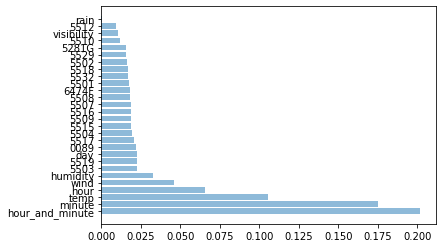

In [37]:
%matplotlib inline
# only in a Jupyter notebook column="delay"

extra_attribs = ["hour_and_minute"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
print(sorted(zip(attributes, feature_importances), key=lambda feature: feature[1], reverse=True))
plt.barh(*zip(*sorted(zip(attributes, feature_importances), key=lambda feature: feature[1], reverse=True)), align='center', alpha=0.5)

We can see that the most important value is the newly added "hour_and_minute" attribute.
### Analyze the Best Models and Their Errors

In [38]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("delay", axis=1)
y_test = strat_test_set["delay"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

4.550072312349575

In [39]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)
The 95% Confidence Interval for the RMSE
np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([4.42050626, 4.67604967])

In [58]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("randomforest", RandomForestRegressor(random_state=42))
    ])

# cut the train test because of memory problems
full_pipeline_with_predictor.fit(delay[:5000], delay_labels[:5000])

# print(some_labels.array)
# print(full_pipeline_with_predictor.predict(some_data))

test_set = strat_test_set.drop("delay", axis=1) # drop labels for test set
test_set_labels = strat_test_set["delay"].copy()
print(test_set_labels[:5].array)
print(full_pipeline_with_predictor.predict(test_set[:5]))

<PandasArray>
[0.0, 1.0, 0.0, 2.0, 0.0]
Length: 5, dtype: float64
[ 2.51  0.16 -0.69  1.16  0.35]


### Save the model

In [ ]:
import joblib

my_model = full_pipeline_with_predictor
joblib.dump(my_model, "../models/my_model.pkl") # save

# my_model_loaded = joblib.load("my_model.pkl") # load